In [1]:
!nvidia-smi

Tue May 17 10:13:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 00000000:02:00.0 Off |                    0 |
| 23%   43C    P0    61W / 235W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 00000000:03:00.0 Off |                    0 |
| 23%   

In [2]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [39]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap
from itertools import product

In [47]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *
from helpers.plot_functions import *

In [26]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/exclude_one_training')
spec_file = os.path.join(morph_folder, 'spec_star_restricted.p')

In [11]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [12]:
stim_cats = spec_df.stim.unique().tolist()

In [13]:
spec_list = spec_df.spec.values.tolist()

In [14]:
h, w = spec_list[0].shape

In [15]:
print(h, w)

186 76


In [29]:
spec_df.head()

,stim,id,wav,spec
0,ac,1,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31604236, -0.37852764, -0.4818401, -0.593..."
1,ac,2,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.29399142, -0.3769715, -0.47865176, -0.570..."
2,ac,3,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.2979087, -0.3694466, -0.47737938, -0.5982..."
3,ac,4,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31531733, -0.36380786, -0.47053644, -0.59..."
4,ac,5,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31867203, -0.36792934, -0.4731297, -0.597..."


## make model and load weights

In [16]:
clear_session()

In [17]:
model=self_VGG()

In [18]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
model_outputs = model(resized)
feature_extractor = Model(model_inputs, model_outputs)

In [20]:
def distance_ratio(d1, d2):
    """
    compare the distance between v0-v1 and v0-v2, then put the recognition confidence between v1 and v2"""
    ratio=[]
    try: 
        for d01, d02 in zip(d1, d2):
            ratio.append(d01/(d01+d02))
    except:
        ratio = d1/(d1+d2)
    return ratio

In [21]:
def distance_to_confidence(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then put the recognition confidence between v1 and v2"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    if d01<0.001:
        return 0
    elif d02<0.001:
        return 1
    else:
#         return np.exp(1/d02)/(np.exp(1/d01)+np.exp(1/d02))
        return (1/d02)/(1/d01+1/d02)

In [22]:
def min_distance(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then return the smaller one"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    return min(d01, d02)

In [23]:
def avrg_distance(v0, v1, v2, dist_func):
    """
    compare the distance between v0-v1 and v0-v2, then return the average"""
    d01 = dist_func(v0, v1)
    d02 = dist_func(v0, v2)
    return np.mean([d01, d02])

In [24]:
def flip_at_peak(list1, list2, monotonous=False):
    """
    compare the values in list 1 (monotonously increasing) and list 2 (monotonously decreasing),
    start with list 1 values, once they cross, flip list 2 values based on cross value"""
    
    if monotonous:
        cross_index = np.argmin(np.abs(np.array(list1)-np.array(list2)))
    else:
        diff = np.array(list1)-np.array(list2)
        l1high_indeces = [i for i in range(len(list1)-2) if (diff[i]>0) and (diff[i+1]>0) and (diff[i+2]>0)]
        cross_index = l1high_indeces[0]
    peak_val = list1[cross_index]
    comb_list = list1[:cross_index]+list(2*peak_val-np.array(list2[cross_index:]))
    
    return comb_list

In [30]:
def normalize_robust(l):
    new_l = (np.array(l)-np.median(l[:10]))/np.median(l[-10:])
    new_l[new_l>1]=1.
    new_l[new_l<0]=0
    return list(new_l)

# All groups combined

In [27]:
subjs = sorted(list(set([path.split('/')[-1].split('_')[0] for path in glob(os.path.join(results_folder, '*'))])))

In [28]:
subjs

['B1082', 'B1088', 'B1101', 'B1105', 'B1107', 'B1218', 'B1222', 'B979']

In [32]:
def check_reverse(subj, morph_dim):
    if subj in ['B1088', 'B1105']:
        if morph_dim in [a+b for a, b in list(product('efcd', 'gh'))]:
            return True
        else:
            return False
    elif subj in ['B1101', 'B1222']:
        if morph_dim in [a+b for a, b in list(product('cd', 'ef'))]:
            return True
        else:
            return False
    else:
        return False

In [41]:
cat_list = []
subj_list = []
id_list = []
less_dim_list = []
more_dim_list = []

feature_cosine_list = []
spec_rmse_list = []

p_list = []

for subj in subjs:
    subj_folders = sorted(glob(os.path.join(results_folder, f'{subj}*')))
    for folder in subj_folders:
        
        # 1.0 extract model prediction
        results_file = os.path.join(folder, 'test_results.p')
        if not os.path.exists(results_file):
            continue
        predictions, targets = pickle.load(open(results_file, 'rb'))
        cat = folder.split('/')[-1].split('_')[-1]
        if check_reverse(subj, cat):
            predictions = [1-predict for predict in predictions]
            targets = [1-target for target in targets]
        
        p_list+=list(predictions)
        id_list+=list(np.arange(1,129,1))
        cat_list+= ([cat]*128)
        subj_list+= ([subj]*128)
        
        # 2.0 load model weights to extract feature vectors and APD
        weights_file = os.path.join(folder, 'weights-improvement.h5')
        feature_extractor.load_weights(weights_file, by_name=True)
        cat_specs = spec_df[spec_df.stim==cat].reset_index(drop=True)
        
            # init value
        init_spec = cat_specs[cat_specs.id==1].spec.values[0]
        init_spec_3d = np.stack([init_spec, init_spec, init_spec], axis = 2)
        init_features = np.squeeze(feature_extractor.predict(np.expand_dims(init_spec_3d, axis=0)))

            # last value
        final_spec = cat_specs[cat_specs.id==128].spec.values[0]
        final_spec_3d = np.stack([final_spec, final_spec, final_spec], axis = 2)
        final_features = np.squeeze(feature_extractor.predict(np.expand_dims(final_spec_3d, axis=0)))
        
            # define values for iteration
        feature_cosine_list_init_cat = []
        spec_rmse_list_init_cat = []
        feature_cosine_list_final_cat = []
        spec_rmse_list_final_cat = []
        
            # iterate through morphs
        for _, spec_i, _, spec in cat_specs.values:
            spec_3d = np.stack([spec, spec, spec], axis = 2)

            spec_features = np.squeeze(feature_extractor.predict(np.expand_dims(spec_3d, axis=0)))

            init_feature_cosine = distance.cosine(init_features, spec_features)
            final_feature_cosine = distance.cosine(final_features, spec_features)
            init_spec_rmse = rmse(init_spec_3d, spec_3d)
            final_spec_rmse = rmse(final_spec_3d, spec_3d)

            less_dim_list.append(cat[0])
            more_dim_list.append(cat[1])
            
            feature_cosine_list_init_cat.append(init_feature_cosine)
            feature_cosine_list_final_cat.append(final_feature_cosine)
            spec_rmse_list_init_cat.append(init_spec_rmse)
            spec_rmse_list_final_cat.append(final_spec_rmse)
        
            # append results
            
        feature_cosine_list_ratio_cat = distance_ratio(feature_cosine_list_init_cat, feature_cosine_list_final_cat)
        spec_rmse_list_ratio_cat = distance_ratio(spec_rmse_list_init_cat, spec_rmse_list_final_cat)
        feature_cosine_list += normalize_robust(feature_cosine_list_ratio_cat)
        spec_rmse_list += normalize_robust(spec_rmse_list_ratio_cat)
        
        paragraph_print(f'Done with {subj} {cat}', separation='*')

Done with B1082 ae
**************************************************
Done with B1082 af
**************************************************
Done with B1082 ag
**************************************************
Done with B1082 ah
**************************************************
Done with B1082 be
**************************************************
Done with B1082 bf
**************************************************
Done with B1082 bg
**************************************************
Done with B1082 bh
**************************************************
Done with B1082 ce
**************************************************
Done with B1082 cf
**************************************************
Done with B1082 cg
**************************************************
Done with B1082 ch
**************************************************
Done with B1082 de
**************************************************
Done with B1082 df
**************************************************
Done with B1082 dg
*

Done with B979 bg
**************************************************
Done with B979 bh
**************************************************
Done with B979 ce
**************************************************
Done with B979 cf
**************************************************
Done with B979 cg
**************************************************
Done with B979 ch
**************************************************
Done with B979 de
**************************************************
Done with B979 df
**************************************************
Done with B979 dg
**************************************************
Done with B979 dh
**************************************************


In [42]:
morph_df = pd.DataFrame()
morph_df['subj'] = subj_list
morph_df['morph_dim'] = cat_list
morph_df['id'] = id_list

morph_df['lesser_dim'] = less_dim_list
morph_df['greater_dim'] = more_dim_list

morph_df['norm_feature_cosine'] = feature_cosine_list
morph_df['norm_spec_rmse'] = spec_rmse_list
morph_df['model_prediction'] = p_list

In [43]:
morph_df.tail()

,subj,morph_dim,id,lesser_dim,greater_dim,norm_feature_cosine,norm_spec_rmse,model_prediction
16379,B979,dh,124,d,h,1.000000,0.361444,0.985299
16380,B979,dh,125,d,h,0.986688,0.378649,0.993711
16381,B979,dh,126,d,h,0.986876,0.373815,0.994389
16382,B979,dh,127,d,h,1.000000,0.804536,0.991109
16383,B979,dh,128,d,h,1.000000,0.944771,0.989998


In [60]:
morph_df.to_pickle(os.path.join(save_folder, 'morph.p'))

In [45]:
cohort_subj_dic = {"B979": 'Cohort 3', 
                   "B1107": 'Cohort 3', 
                   "B1082": 'Cohort 3', 
                   "B1218": 'Cohort 3', 
                   "B1088": 'Cohort 1',  
                   "B1105": 'Cohort 1', 
                   "B1222": 'Cohort 2',  
                   "B1101": 'Cohort 2'}
cohort_palette = {'Cohort 1':'b', 'Cohort 2': 'g', 'Cohort 3': 'y'}
subj_palette = {"B979": 'gold', 
               "B1107": 'orange', 
               "B1082": 'darkorange', 
               "B1218": 'khaki', 
               "B1088": 'steelblue',  
               "B1105": 'deepskyblue', 
               "B1222": 'darkolivegreen',  
               "B1101": 'darkseagreen'}

../star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
../star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:533: 

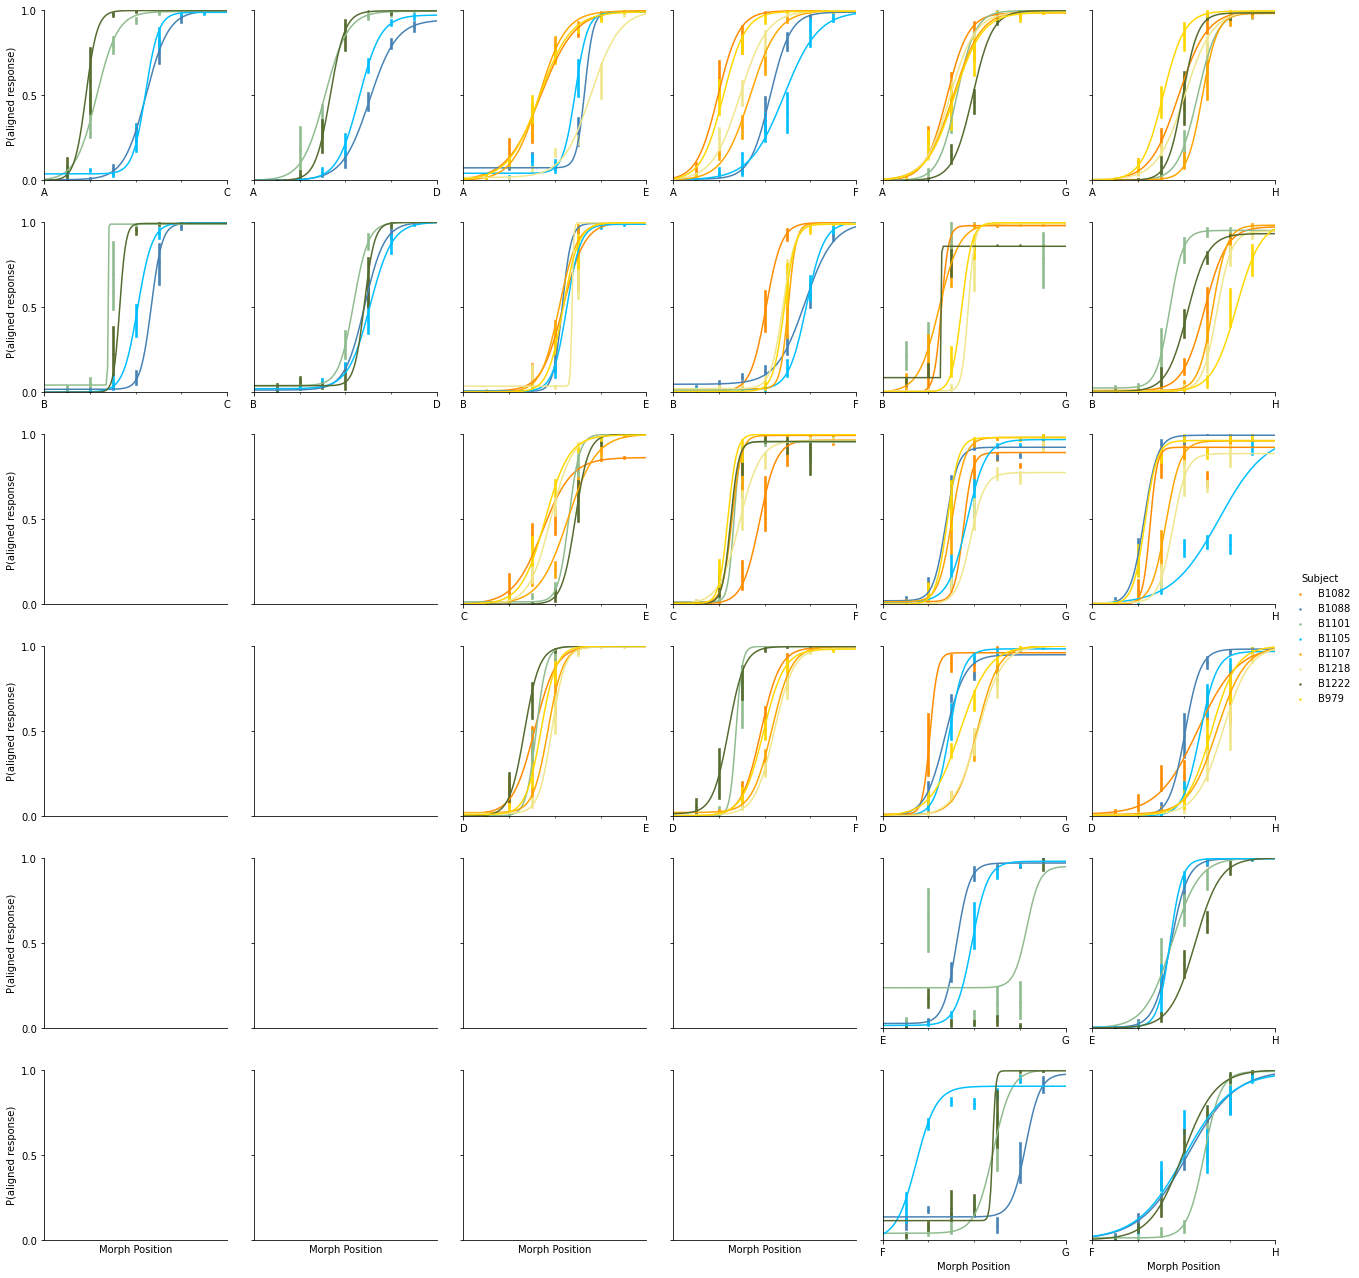

In [48]:
plot_psychometric(morph_df,
                  x='id',
                  y='norm_feature_cosine',
                  hue='subj',
                  scatter_kws={"s": 2},
                  x_bins=7,
                  col_order="cdefgh",
                  row_order="abcdef",
                  fit_reg='4pl',
                  custom_palette=subj_palette,)

../star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
../star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2


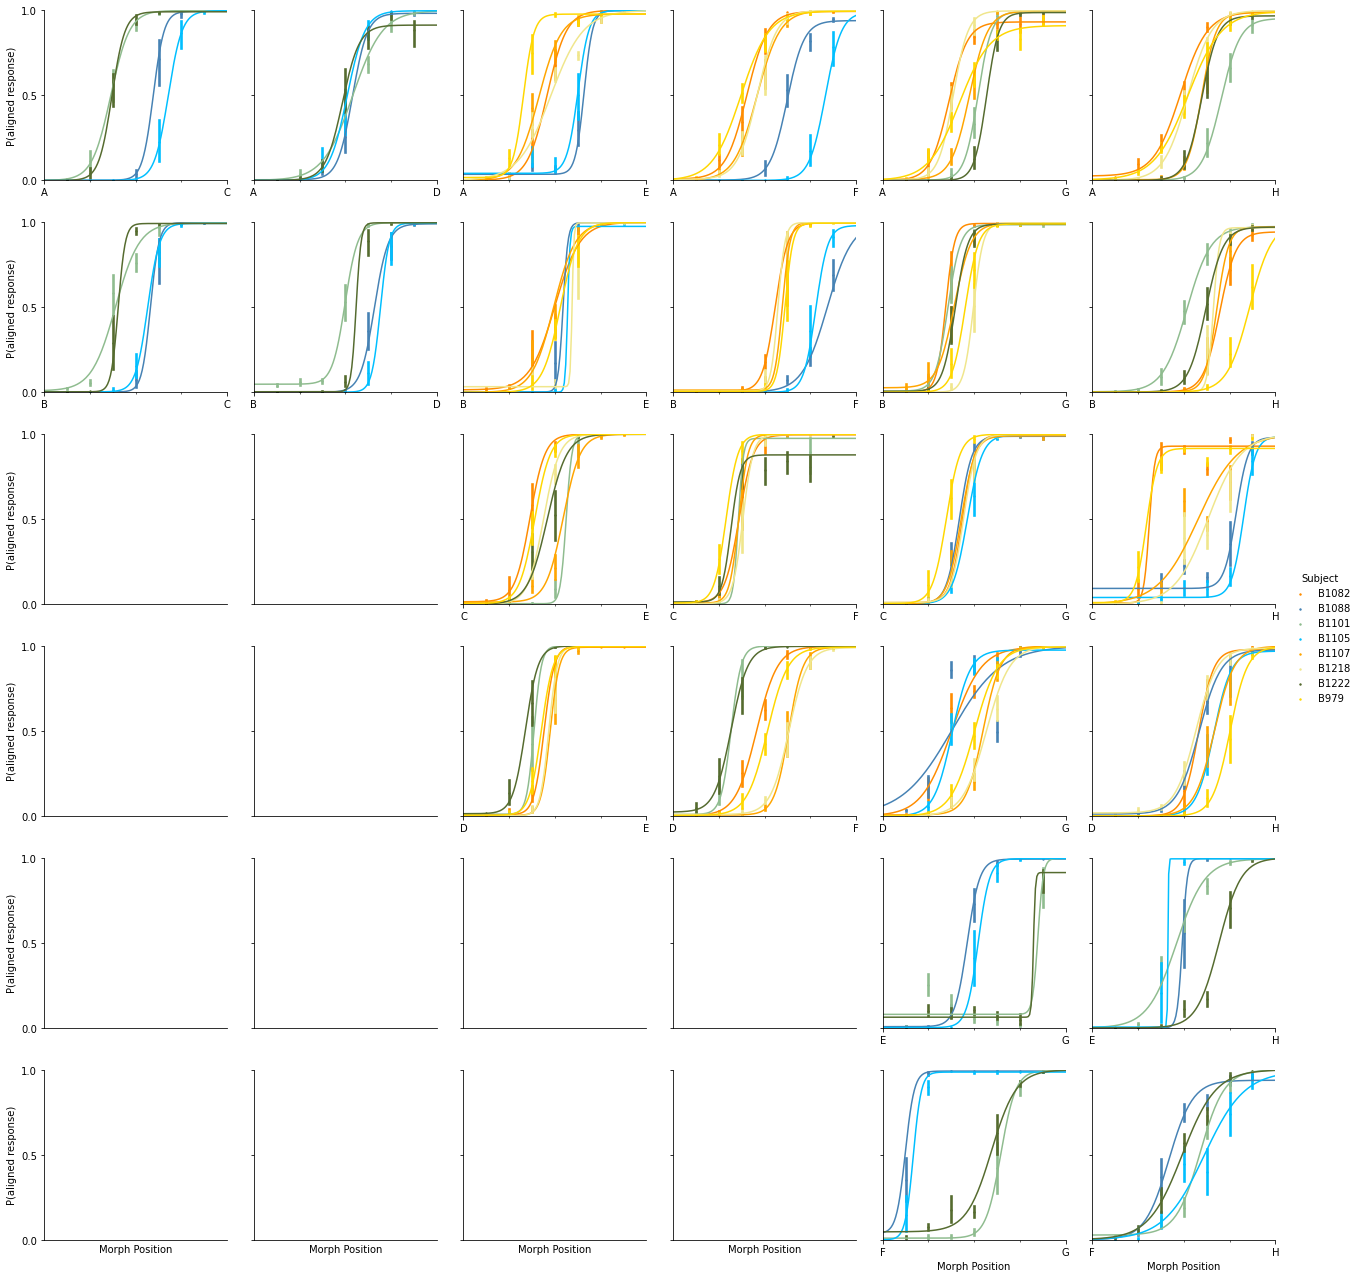

In [49]:
plot_psychometric(morph_df,
                  x='id',
                  y='model_prediction',
                  hue='subj',
                  scatter_kws={"s": 2},
                  x_bins=7,
                  col_order="cdefgh",
                  row_order="abcdef",
                  fit_reg='4pl',
                  custom_palette=subj_palette,)

# combine into df

In [50]:
def generate_group_stims(group):
    group_dic = {'1': ('abcd', 'efgh'), '2': ('abgh', 'cdef'), '3':('abef', 'cdgh')}
    return generate_stim_combos(group_dic[group][0], group_dic[group][1])

## 4pl

In [51]:
all_df = pd.DataFrame()

for subj in subjs:    
    subj_fcosine = {}
    subj_rmse = {}
    subj_model = {}
    subj_df = morph_df[morph_df.subj==subj].reset_index(drop=True)
    subj_cats = subj_df.morph_dim.unique()
    
    for morph_dim in subj_cats:
        
        reduced_morph_df = subj_df[subj_df.morph_dim==morph_dim].reset_index(drop=True)
        ids = np.array(reduced_morph_df.id.values.tolist())
        fcosine_l = np.array(reduced_morph_df.norm_feature_cosine.values.tolist())
        rmse_l = np.array(reduced_morph_df.norm_spec_rmse.values.tolist())
        model_l = np.array(reduced_morph_df.model_prediction.values.tolist())
        
        fcosine_p = fit_4pl(ids, fcosine_l)
        rmse_p = fit_4pl(ids, rmse_l)
        model_p = fit_4pl(ids, model_l)

        if isinstance(fcosine_p, bool) or isinstance(model_p, bool) or isinstance(rmse_p, bool):
            continue
        else:
            subj_fcosine[morph_dim] = fcosine_p
            subj_model[morph_dim] = model_p
            subj_rmse[morph_dim] = rmse_p
    subj_df_rmse = pd.DataFrame.from_dict(subj_rmse, 
                                                orient='index', 
                                                columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
    subj_df_model = pd.DataFrame.from_dict(subj_model, 
                                                orient='index', 
                                                columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()
    subj_df_fcosine = pd.DataFrame.from_dict(subj_fcosine, 
                                                orient='index', 
                                                columns=['min_val', 'max_val', 'slope', 'inflection']).reset_index()

    subj_df_rmse['subj'] = subj
    subj_df_model['subj'] = subj
    subj_df_fcosine['subj'] = subj

    subj_df_rmse['metric'] = 'rmse'
    subj_df_model['metric'] = 'nn'
    subj_df_fcosine['metric'] = 'fcosine'

    subj_df_comb = pd.concat([subj_df_rmse, subj_df_model, subj_df_fcosine]).reset_index(drop=True)
    all_df = pd.concat([all_df, subj_df_comb]).reset_index(drop=True)

../star_scale/math_utils.py:397: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:533: RuntimeWarning: overflow encountered in exp
  return A + (K - A) / (1 + np.exp(-B * (x - M)))
../star_scale/math_utils.py:536: RuntimeWarning: overflow encountered in exp
  temp1 = np.exp(-B * (x - M))
../star_scale/math_utils.py:539: RuntimeWarning: overflow encountered in square
  temp2 = temp1 / (1.0 + temp1) ** 2
../star_scale/math_utils.py:539: RuntimeWarning: invalid value encountered in true_divide
  temp2 = temp1 / (1.0 + temp1) ** 2


In [52]:
all_df

,index,min_val,max_val,slope,inflection,subj,metric
0,ae,1.000000e-16,1.000000,0.029875,79.470487,B1082,rmse
1,af,1.000000e-16,0.568973,0.050084,67.639823,B1082,rmse
2,ag,1.000000e-16,0.565611,0.057494,63.763143,B1082,rmse
3,ah,1.000000e-16,1.000000,0.022960,125.997597,B1082,rmse
4,be,1.000000e-16,0.980336,0.036597,100.000082,B1082,rmse
...,...,...,...,...,...,...,...
373,ch,2.376547e-04,0.962417,0.239380,37.530092,B979,fcosine
374,de,8.561821e-03,0.999344,0.187990,54.850318,B979,fcosine
375,df,6.439913e-04,0.982075,0.137907,63.647337,B979,fcosine
376,dg,1.000000e-16,1.000000,0.099434,54.684136,B979,fcosine


In [53]:
results_folder

'/mnt/cube/kai/results/perceptual_loss/2021_10_14_10_55_07/exclude_one_training'

In [56]:
save_folder=extend_folder('/mnt/cube/kai/results/perceptual_loss/morph', 'holdout')

In [58]:
all_df.to_pickle(os.path.join(save_folder, 'all_predicted.p'))